# Statistical Analysis: Genius Song Lyrics Subset (1%)

**Dataset:** 51'349 Songs | 5'333 Artists | 6 Genres

**Purpose:** Explore patterns and distributions in song lyrics across genres and artists. Focus on word frequencies, stylistic differences and similarity structures.

---

# 1. Dataset Overview
## 1.1 Import Packages and Settings

In [66]:
import pandas as pd
import re
from collections import defaultdict, Counter
from itertools import tee
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

In [67]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

## 1.2 Load Dataset

In [68]:
df = pd.read_csv('data/clean/lyrics_subset_1pct_clean.csv')
df = df[df["language_cld3"] == "en"]
# nur englische Songs was für eine Auswertung einfacher ist
print(f"DataFrame shape: {df.shape}")
print(f"Number of Songs: {len(df)} | Artists: {df['artist'].nunique()}")
df.head()

DataFrame shape: (34049, 11)
Number of Songs: 34049 | Artists: 26408


,title,tag,artist,year,views,features,id,language_cld3,language_ft,language,lyrics
0,2 Is Better 棍子,rap,Chris Travis,2017,4437,{},3036329,en,en,en,Bitch I'm clean Two sticks like Chow Mein Two ...
1,Scottie,rap,KrJ,2012,89,{},72180,en,en,en,My old girl left me on her old bull shit So I ...
2,Pirate Password,rock,The never land pirate band,2011,175,{},2122100,en,en,en,Avast there matey haha If a pirate asks ya for...
3,Indri,rock,Puta Volcano,2015,14,{},6889288,en,en,en,Just throw a glimpse under the shell Ghostly v...
4,Maps,misc,ANBARDA,2018,4,{},3735887,en,en,en,I miss the taste of a sweeter life I miss the ...


## 1.3 Descriptive Statistics

In [69]:
# Genre distribution
print("\nGENRE DISTRIBUTION")
print("=" * 60)
category_counts = df['tag'].value_counts().sort_values(ascending=False)

for tag,count in category_counts.items():
    pct = (count / len(df)) * 100
    print(f"{tag}: {count:,} songs ({pct:.2f}%)")


GENRE DISTRIBUTION
pop: 14,100 songs (41.41%)
rap: 9,723 songs (28.56%)
rock: 6,375 songs (18.72%)
rb: 1,531 songs (4.50%)
misc: 1,450 songs (4.26%)
country: 870 songs (2.56%)


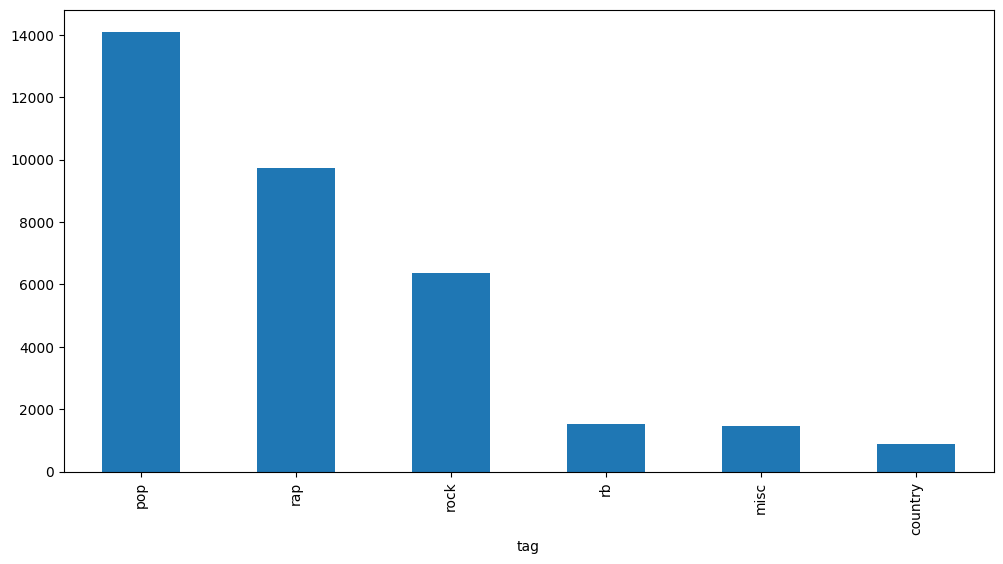

In [70]:
category_counts.plot(kind="bar")
plt.show()

# 1.3.1 Tokenizer
### Textbereinigung & Tokenisierung

In [71]:
def preprocess_text(text, lowercase=True):
    """Clean and tokenize text"""
    if not isinstance(text, str):
        return []
    if lowercase:
        text = text.lower()
    # Entfernt Sonderzeichen, behält Satzzeichen und Apostrophe
    text = re.sub(r"[^a-z0-9\s\.\,\!\?\-\'\"]+", "", text)
    # Tokenisierung nach Leerzeichen
    tokens = text.split()
    return tokens

### Stopwort-Filter

In [72]:
STOPWORDS = {
    "the","a","an","and","or","but","if","then","so","than","that","those","these","this",
    "to","of","in","on","for","with","as","at","by","from","into","over","under","up","down",
    "is","am","are","was","were","be","been","being","do","does","did","doing","have","has","had",
    "i","you","he","she","it","we","they","me","him","her","us","them","my","your","his","its","our","their",
    "not","no","yes","yeah","y'all","yall","im","i'm","i’d","i'd","i’ll","i'll","youre","you're","dont","don't",
    "cant","can't","ill","i’ll","id","i'd","ive","i’ve","ya","oh","ooh","la","na","nah"
}

def filtered_tokens(text):
    """Tokenisierung + Stopwort-Filter"""
    tokens = preprocess_text(text)
    return [t for t in tokens if t not in STOPWORDS and not t.isdigit() and len(t) > 1]

### Visualisierung

Total tokens: 6226610
Unique tokens: 216493

First 20 tokens: ['bitch', 'clean', 'two', 'sticks', 'like', 'chow', 'mein', 'two', 'sticks', 'like', 'chow', 'mein', 'bitch', 'clean', 'two', 'sticks', 'like', 'chow', 'mein', 'two']


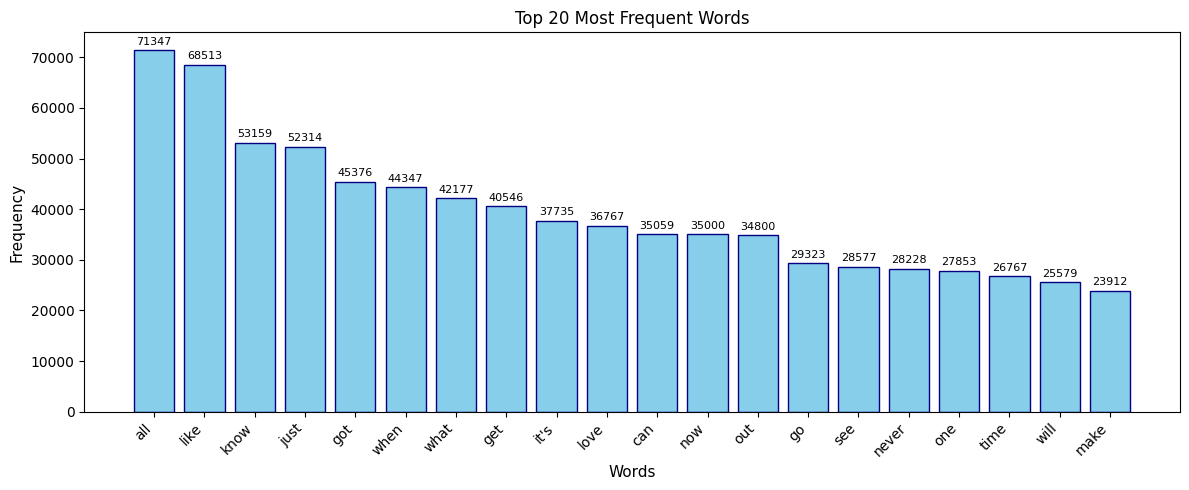

In [73]:
df["tokens"] = df["lyrics"].apply(filtered_tokens)

# Alle Tokens in einer Liste zusammenfassen
tokens_per_row = df["tokens"]
tokens = [t for row in tokens_per_row for t in row]

print(f"Total tokens: {len(tokens)}")
print(f"Unique tokens: {len(set(tokens))}")
print(f"\nFirst 20 tokens: {tokens[:20]}")
def plot_frequency_distribution(tokens, top_n=20):
    """Plot word frequency distribution"""
    word_counts = Counter(tokens)
    most_common = word_counts.most_common(top_n)
    
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 5))
    bars = plt.bar(range(len(words)), counts, color='skyblue', edgecolor='navy')
    plt.xlabel('Words', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title(f'Top {top_n} Most Frequent Words', fontsize=12)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
plot_frequency_distribution(tokens, top_n=20)

# 1.3.2 Unigramme / Bigramme / Trigramme

### Unigramme / Bigramme / Trigramme

In [74]:
def ngrams(tokens, n):
    """Erzeuge n-Gramme als Tupel über ein slide window."""
    if n <= 0:
        return []
    iters = tee(tokens, n)
    for i, it in enumerate(iters):
        for _ in range(i):
            next(it, None)
    return zip(*iters)

# Unigramme (einfach die Tokens)
all_tokens = [t for toks in df["tokens"] for t in toks]
unigram_counts = Counter(all_tokens)

# Bigramme & Trigramme (global)
bigram_counts = Counter()
trigram_counts = Counter()
for toks in df["tokens"]:
    bigram_counts.update(ngrams(toks, 2))
    trigram_counts.update(ngrams(toks, 3))

print("\nTop 20 Unigramme (gesamt):")
for w, c in unigram_counts.most_common(20):
    print(f"{w:>15s}  {c}")

print("\nTop 15 Bigramme (gesamt):")
for bg, c in bigram_counts.most_common(15):
    print(f"{' '.join(bg):>25s}  {c}")

print("\nTop 15 Trigramme (gesamt):")
for tg, c in trigram_counts.most_common(15):
    print(f"{' '.join(tg):>35s}  {c}")




Top 20 Unigramme (gesamt):
            all  71347
           like  68513
           know  53159
           just  52314
            got  45376
           when  44347
           what  42177
            get  40546
           it's  37735
           love  36767
            can  35059
            now  35000
            out  34800
             go  29323
            see  28577
          never  28228
            one  27853
           time  26767
           will  25579
           make  23912

Top 15 Bigramme (gesamt):
                know what  4716
                feel like  3378
                   let go  2893
                just like  2677
                 know how  2301
              yeah, yeah,  2271
                  can see  2253
               just wanna  2239
                 it's all  2090
                right now  2012
                  oh, oh,  1992
                 i've got  1905
               every time  1861
                 too much  1827
                all night  1708

Top 

### Visualisierung

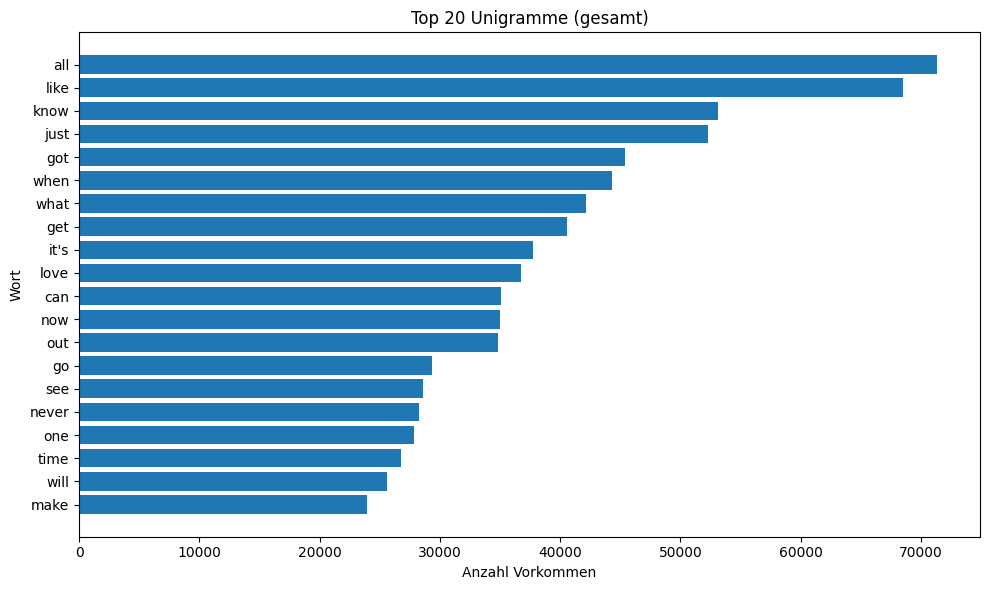

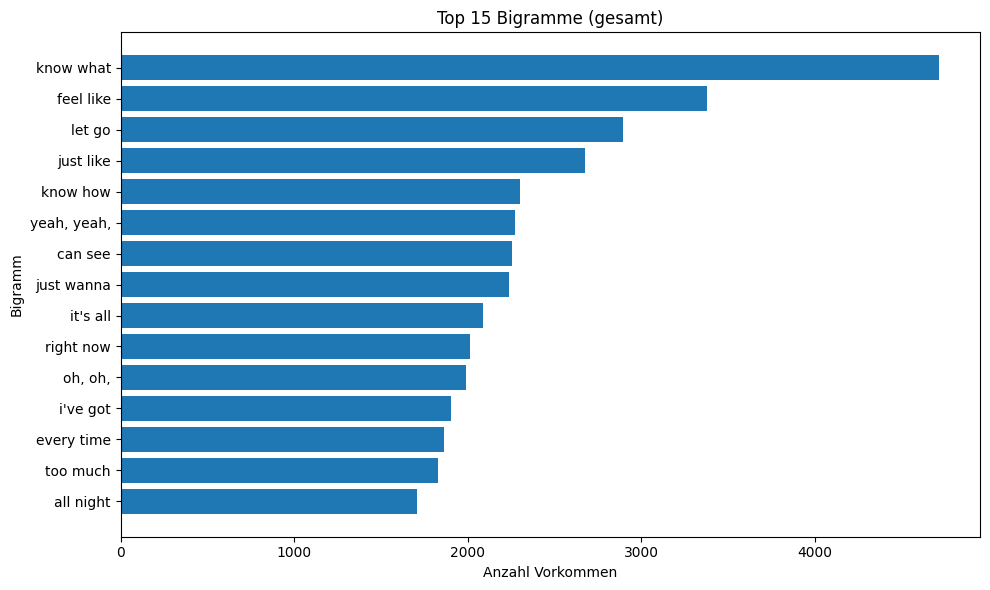

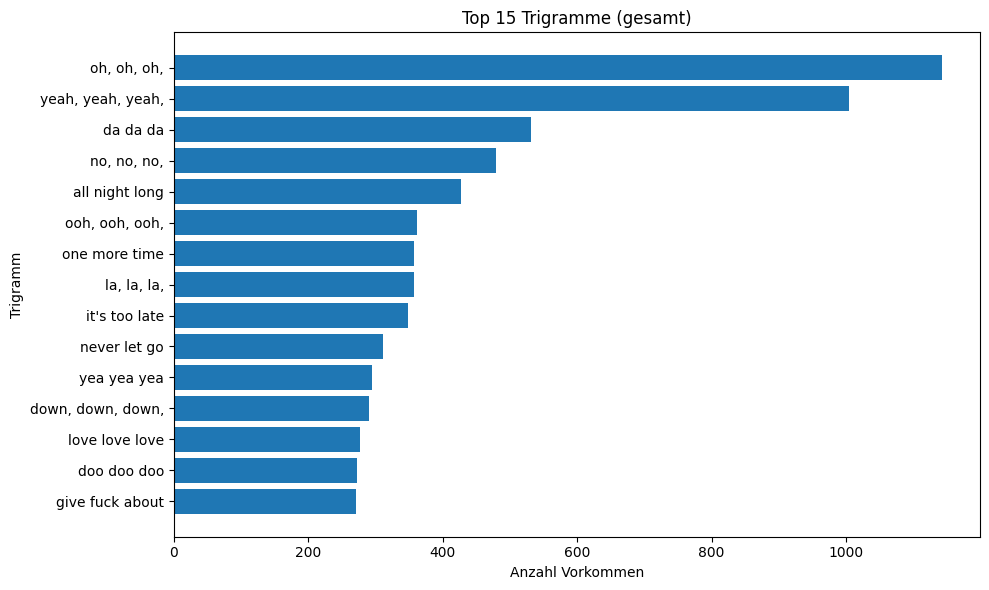


Top 20 Unigramme:
     word  count
0     all  71347
1    like  68513
2    know  53159
3    just  52314
4     got  45376
5    when  44347
6    what  42177
7     get  40546
8    it's  37735
9    love  36767
10    can  35059
11    now  35000
12    out  34800
13     go  29323
14    see  28577
15  never  28228
16    one  27853
17   time  26767
18   will  25579
19   make  23912

Top 15 Bigramme:
         bigram  count
0     know what   4716
1     feel like   3378
2        let go   2893
3     just like   2677
4      know how   2301
5   yeah, yeah,   2271
6       can see   2253
7    just wanna   2239
8      it's all   2090
9     right now   2012
10      oh, oh,   1992
11     i've got   1905
12   every time   1861
13     too much   1827
14    all night   1708

Top 15 Trigramme:
              trigram  count
0         oh, oh, oh,   1142
1   yeah, yeah, yeah,   1005
2            da da da    531
3         no, no, no,    479
4      all night long    427
5      ooh, ooh, ooh,    362
6       one more

In [75]:
unigram_counts = Counter()
bigram_counts = Counter()
trigram_counts = Counter()

for tokens in df["tokens"]:
    unigram_counts.update(tokens)
    bigram_counts.update(ngrams(tokens, 2))
    trigram_counts.update(ngrams(tokens, 3))

# Top N-Gramme extrahieren
top_unigrams = pd.DataFrame(unigram_counts.most_common(20), columns=["word", "count"])
top_bigrams = pd.DataFrame(
    [(" ".join(k), v) for k, v in bigram_counts.most_common(15)],
    columns=["bigram", "count"]
)
top_trigrams = pd.DataFrame(
    [(" ".join(k), v) for k, v in trigram_counts.most_common(15)],
    columns=["trigram", "count"]
)
plt.figure(figsize=(10, 6))
plt.barh(top_unigrams["word"][::-1], top_unigrams["count"][::-1])
plt.title("Top 20 Unigramme (gesamt)")
plt.xlabel("Anzahl Vorkommen")
plt.ylabel("Wort")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_bigrams["bigram"][::-1], top_bigrams["count"][::-1])
plt.title("Top 15 Bigramme (gesamt)")
plt.xlabel("Anzahl Vorkommen")
plt.ylabel("Bigramm")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_trigrams["trigram"][::-1], top_trigrams["count"][::-1])
plt.title("Top 15 Trigramme (gesamt)")
plt.xlabel("Anzahl Vorkommen")
plt.ylabel("Trigramm")
plt.tight_layout()
plt.show()

print("\nTop 20 Unigramme:")
print(top_unigrams)

print("\nTop 15 Bigramme:")
print(top_bigrams)

print("\nTop 15 Trigramme:")
print(top_trigrams)

# 1.3.3 Häufigstes NGramm overall, pro Artist und pro Tag/Genre

### Häufigstes NGramm overall, pro Artist und pro Tag/Genre

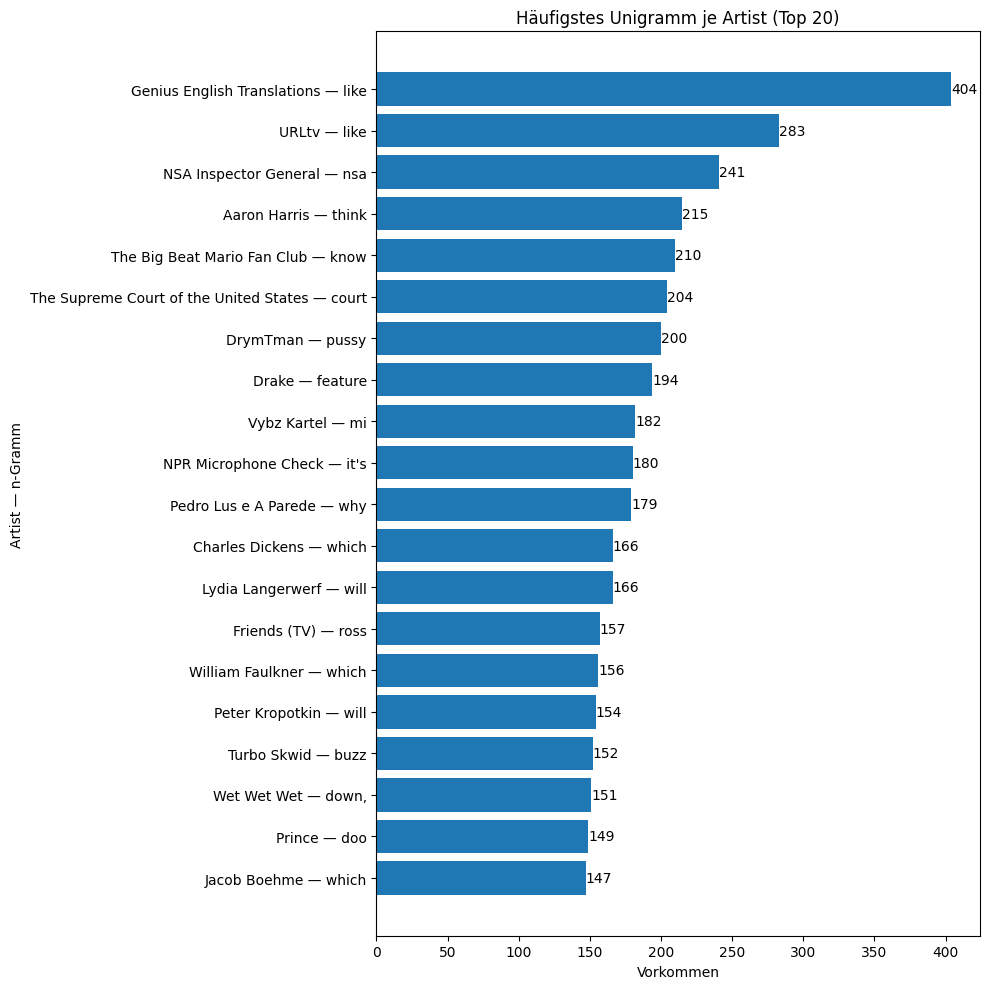

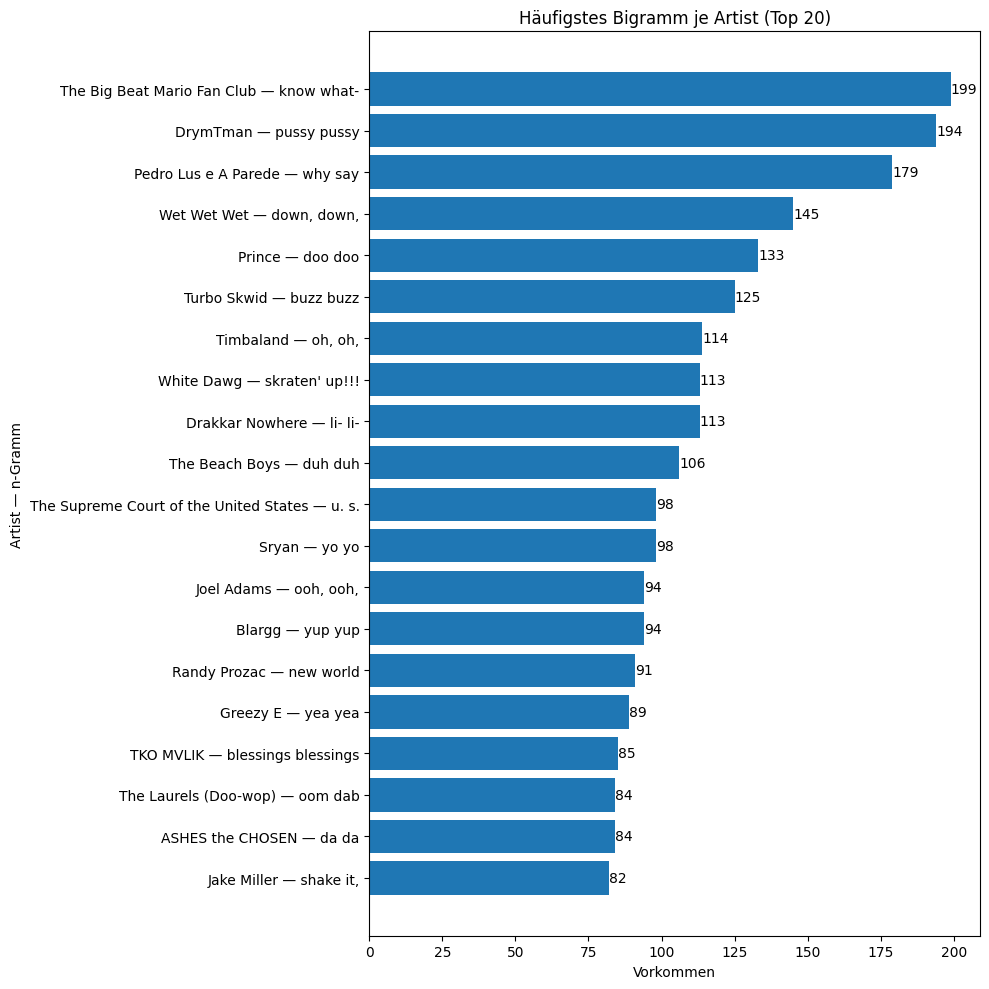

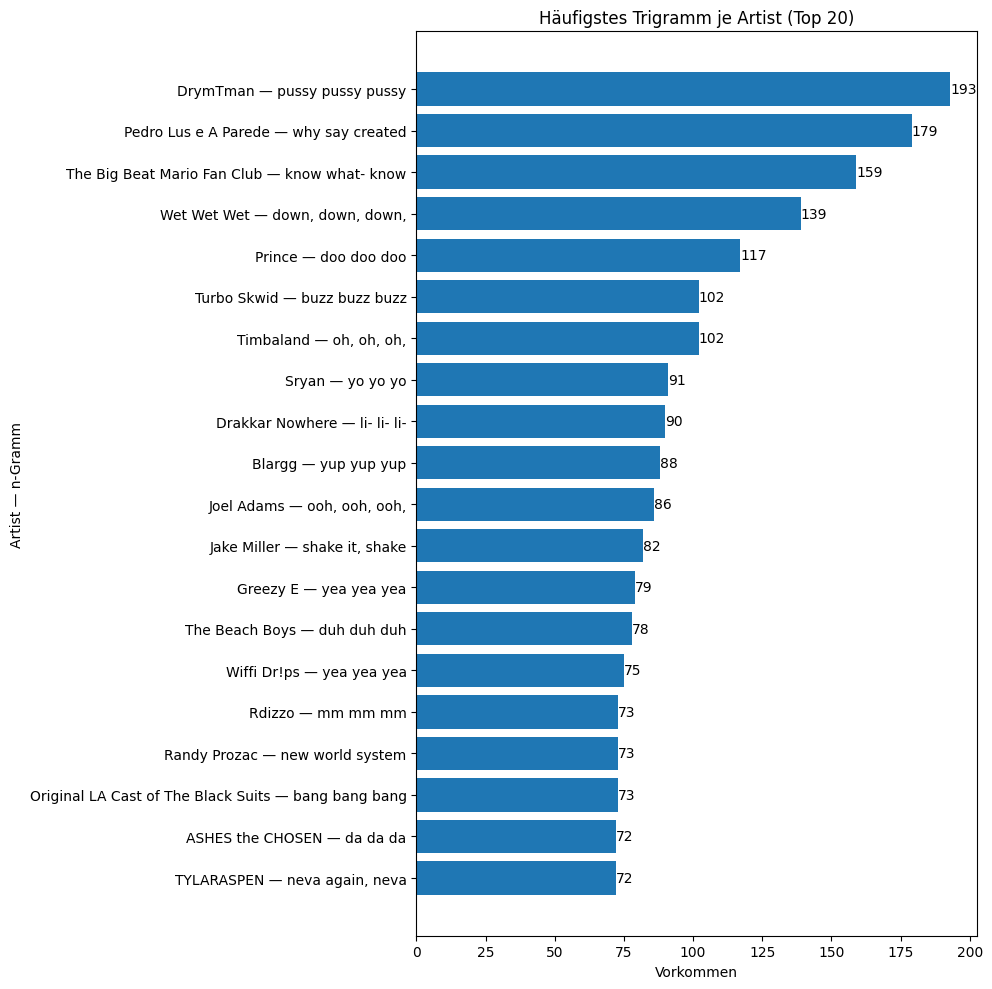

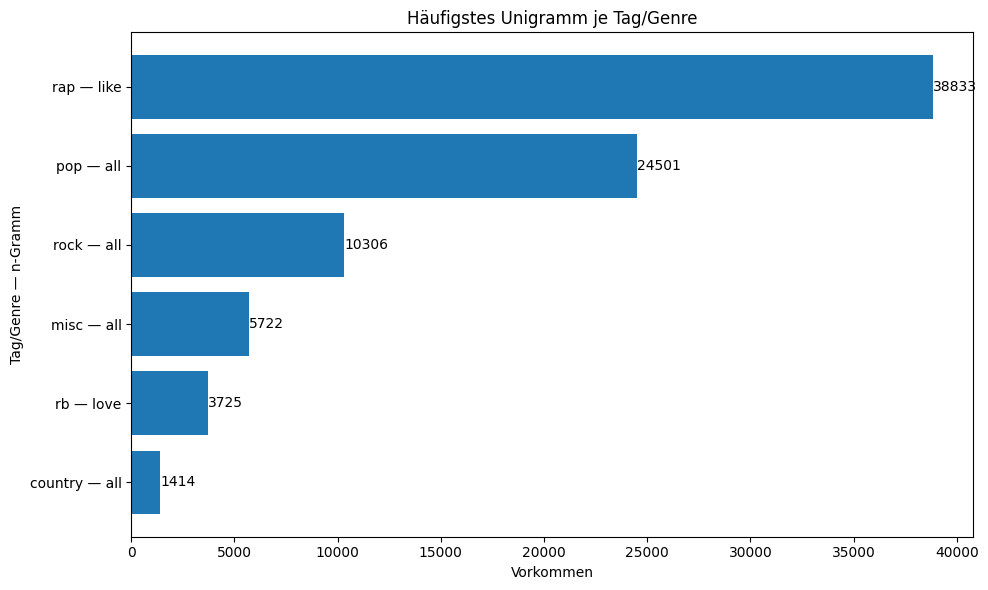

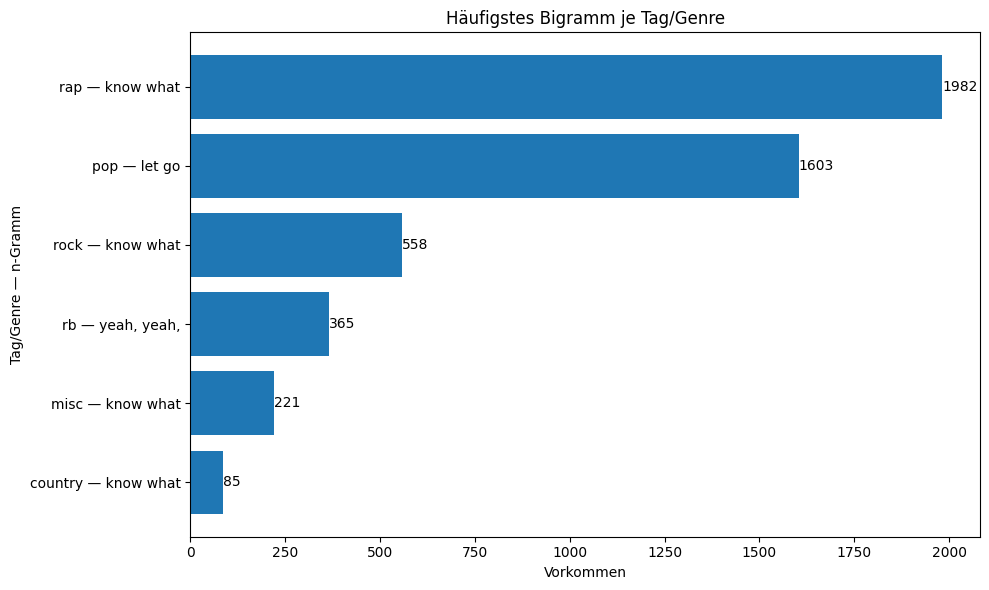

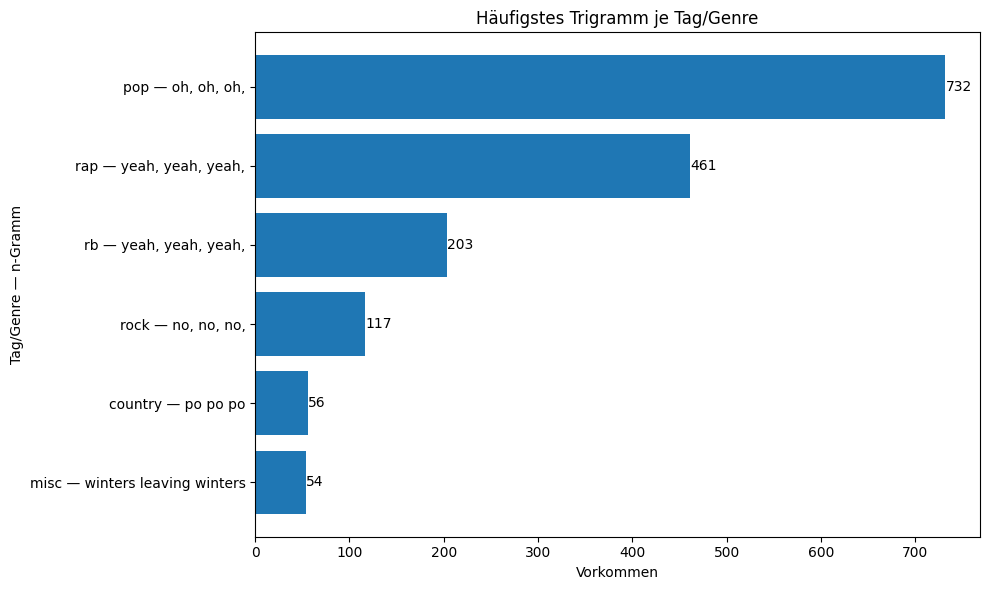

In [76]:
def most_common_ngram_for_group(group_df: pd.DataFrame, label_col: str, n: int) -> pd.DataFrame:
    """
    Liefert pro Gruppe (Artist/Tag) das häufigste n-Gramm mit Count.
    Spalten: [label_col, 'ngram', 'count', 'songs']
    """
    rows = []
    for label, sub in group_df.groupby(label_col):
        c = Counter()
        for toks in sub["tokens"]:
            c.update(ngrams(toks, n))
        if c:
            top_ngram, cnt = c.most_common(1)[0]
            rows.append({label_col: label, "ngram": " ".join(top_ngram), "count": cnt, "songs": len(sub)})
        else:
            rows.append({label_col: label, "ngram": None, "count": 0, "songs": len(sub)})
    return pd.DataFrame(rows).sort_values([label_col]).reset_index(drop=True)

def plot_barh(labels, values, title, xlabel, ylabel, annotate=True, figsize=(10, 6)):
    """Einfaches horizontales Balkendiagramm (keine Styles/Farben gesetzt)."""
    plt.figure(figsize=figsize)
    plt.barh(labels[::-1], values[::-1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if annotate:
        for y, v in enumerate(values[::-1]):
            plt.text(v, y, str(v), va="center", ha="left")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------
# 4) PRO ARTIST: häufigstes Unigramm/Bigramm/Trigramm je Artist
#    (Visualisierung: Top-K Artists nach Count)
# -------------------------------------------------------
per_artist_uni = most_common_ngram_for_group(df, "artist", n=1)
per_artist_bi  = most_common_ngram_for_group(df, "artist", n=2)
per_artist_tri = most_common_ngram_for_group(df, "artist", n=3)

# Top-K nach Count für bessere Lesbarkeit
K = 20  # Anzahl Artists, die geplottet werden
for name, d in [
    (f"Häufigstes Unigramm je Artist (Top {K})", per_artist_uni),
    (f"Häufigstes Bigramm je Artist (Top {K})",  per_artist_bi),
    (f"Häufigstes Trigramm je Artist (Top {K})", per_artist_tri),
]:
    if not d.empty:
        d_plot = d.sort_values("count", ascending=False).head(K).copy()
        d_plot["label"] = d_plot["artist"].astype(str) + " — " + d_plot["ngram"].astype(str)
        plot_barh(d_plot["label"], d_plot["count"], name, "Vorkommen", "Artist — n-Gramm",
                  annotate=True, figsize=(10, 10))

# -------------------------------------------------------
# 5) PRO TAG/GENRE: häufigstes Unigramm/Bigramm/Trigramm je Tag
# -------------------------------------------------------
per_tag_uni = most_common_ngram_for_group(df, "tag", n=1)
per_tag_bi  = most_common_ngram_for_group(df, "tag", n=2)
per_tag_tri = most_common_ngram_for_group(df, "tag", n=3)

for name, d in [
    ("Häufigstes Unigramm je Tag/Genre", per_tag_uni),
    ("Häufigstes Bigramm je Tag/Genre",  per_tag_bi),
    ("Häufigstes Trigramm je Tag/Genre", per_tag_tri),
]:
    if not d.empty:
        d_plot = d.sort_values("count", ascending=False).copy()
        d_plot["label"] = d_plot["tag"].astype(str) + " — " + d_plot["ngram"].astype(str)
        plot_barh(d_plot["label"], d_plot["count"], name, "Vorkommen", "Tag/Genre — n-Gramm",
                  annotate=True, figsize=(10, 6))

# 1.3.4 Häufigstes Wort overall, pro Artist und pro Tag/Genre

### Häufigstes Wort overall, pro Artist und pro Tag/Genre


In [77]:
overall_most_common = unigram_counts.most_common(1)[0] if unigram_counts else (None, 0)
print(f"\nHäufigstes Wort (overall): {overall_most_common[0]!r} mit {overall_most_common[1]} Vorkommen")

def most_common_for_group(group_df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    """Ermittelt das häufigste Wort pro Gruppe (z. B. je 'artist' oder je 'tag')."""
    rows = []
    for label, sub in group_df.groupby(label_col):
        tokens = [t for toks in sub["tokens"] for t in toks]
        c = Counter(tokens)
        if c:
            word, count = c.most_common(1)[0]
            rows.append({label_col: label, "word": word, "count": count, "songs": len(sub)})
        else:
            rows.append({label_col: label, "word": None, "count": 0, "songs": len(sub)})
    return pd.DataFrame(rows).sort_values([label_col]).reset_index(drop=True)

per_artist_df = most_common_for_group(df, "artist")
per_tag_df = most_common_for_group(df, "tag")

print("\nHäufigstes Wort je Artist (Top 10 Zeilen):")
print(per_artist_df.head(10).to_string(index=False))

print("\nHäufigstes Wort je Tag/Genre:")
print(per_tag_df.to_string(index=False))


Häufigstes Wort (overall): 'all' mit 71347 Vorkommen

Häufigstes Wort je Artist (Top 10 Zeilen):
                  artist       word  count  songs
   (Your gentle madness) halloween,     17      1
     (Alexander Pushkin)      tears      2      2
           (Lena Katina)   saxobeat     12      1
           (Leo Tolstoy)       said     75      9
           (Mumiy Troll)     normal      2      1
           (Nasha Tanie)       time      5      2
        (Sergey Lazarev)        all      8      2
      (Verka Serdyuchka)       make     40      1
          (dima bamberg)     what's      2      1
             (AAA) (JPN)        wow     10      1

Häufigstes Wort je Tag/Genre:
    tag word  count  songs
country  all   1414    870
   misc  all   5722   1450
    pop  all  24501  14100
    rap like  38833   9723
     rb love   3725   1531
   rock  all  10306   6375


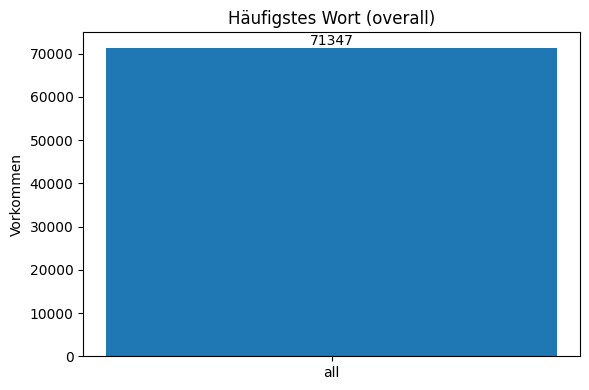

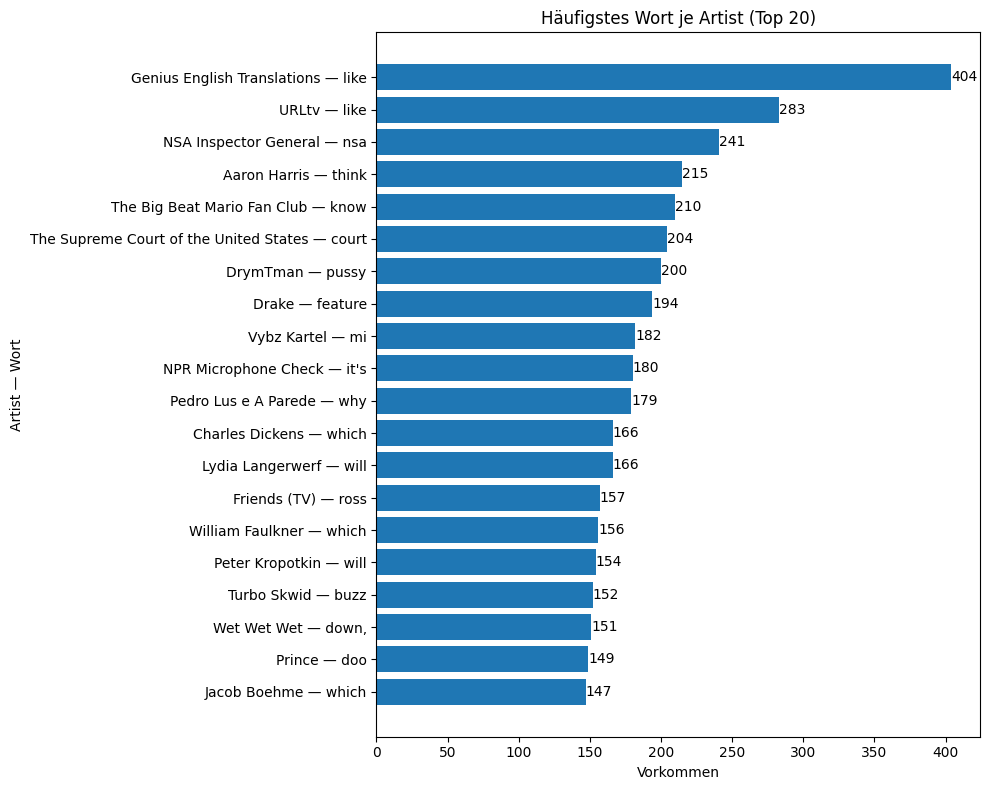

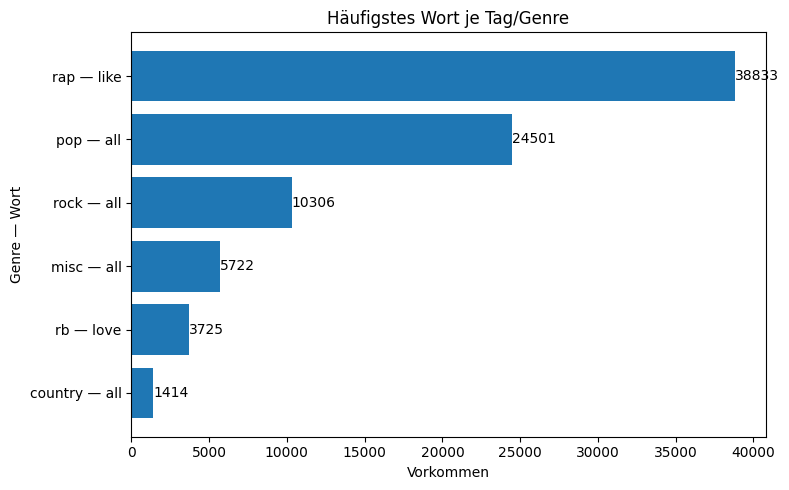

In [78]:
plt.figure(figsize=(6, 4))
label = overall_most_common[0] if overall_most_common[0] is not None else "(kein Wort)"
count = overall_most_common[1]
plt.bar([label], [count])
plt.title("Häufigstes Wort (overall)")
plt.ylabel("Vorkommen")
for i, v in enumerate([count]):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 4b) Häufigstes Wort je Artist – Top 20 nach Count
if not per_artist_df.empty:
    topN = 20 if len(per_artist_df) > 20 else len(per_artist_df)
    artist_plot_df = per_artist_df.sort_values("count", ascending=False).head(topN).copy()
    # Label: "Artist — Wort"
    artist_plot_df["label"] = artist_plot_df["artist"].astype(str) + " — " + artist_plot_df["word"].astype(str)

    plt.figure(figsize=(10, 8))
    plt.barh(artist_plot_df["label"][::-1], artist_plot_df["count"][::-1])
    plt.title(f"Häufigstes Wort je Artist (Top {topN})")
    plt.xlabel("Vorkommen")
    plt.ylabel("Artist — Wort")
    # Werte an die Balken schreiben
    for y, v in enumerate(artist_plot_df["count"][::-1].values):
        plt.text(v, y, str(v), va="center", ha="left")
    plt.tight_layout()
    plt.show()

# 4c) Häufigstes Wort je Tag/Genre – alle oder Top K
if not per_tag_df.empty:
    tag_plot_df = per_tag_df.sort_values("count", ascending=False).copy()
    tag_plot_df["label"] = tag_plot_df["tag"].astype(str) + " — " + tag_plot_df["word"].astype(str)

    plt.figure(figsize=(8, 5))
    plt.barh(tag_plot_df["label"][::-1], tag_plot_df["count"][::-1])
    plt.title("Häufigstes Wort je Tag/Genre")
    plt.xlabel("Vorkommen")
    plt.ylabel("Genre — Wort")
    for y, v in enumerate(tag_plot_df["count"][::-1].values):
        plt.text(v, y, str(v), va="center", ha="left")
    plt.tight_layout()
    plt.show()

# 1.4 Word Embedding

In [79]:
df['tokens'] = df['lyrics'].apply(lambda x: word_tokenize(x.lower()))